In [27]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

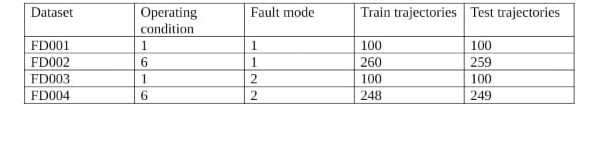

some basic information about dataset

**importing reuired librarys**

In [28]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [29]:
# define column names for easy indexing
index_names = ['unit', 'cycles']
setting_names = ['OPsetting_1', 'OPsetting_2', 'OPsetting_3']
sensor_names = ['sensor {}'.format(i) for i in range(1,22)] 
col_names = index_names + setting_names + sensor_names

# read data
train = pd.read_csv(('/kaggle/input/dataset/_test_FD001.txt'), sep='\s+', header=None, names=col_names)
test = pd.read_csv(('/kaggle/input/dataset/_test_FD001.txt'), sep='\s+', header=None, names=col_names)
y_test = pd.read_csv(('/kaggle/input/dataset/_RUL_FD001.txt'), sep='\s+', header=None, names=['RUL'])

#to print data
train

In [30]:
train[index_names].describe()
#train[index_names].groupby('unit').max().describe()
#train[index_names].groupby('cycles').max().describe()
train= train.dropna()
train = train.reset_index(drop = True)
train


In [31]:
train[setting_names].describe()

In [32]:
train[sensor_names].describe().transpose()

standard deviation of sensor 1,18,19 is zero it shows that value of sensor 1,18,19 is remaning constant throughout the data

# **calculating target variable.**

calculating maximum number of cycles

In [33]:
grouped_by_unit = train.groupby(by="unit")
grouped_by_unit.head()
max_cycle = grouped_by_unit["cycles"].max()
max_cycle

In [34]:
def calculateRUL(df):
    
    #calculating max cycle for each unit
    grouped_by_unit = df.groupby(by="unit")
    max_cycle = grouped_by_unit["cycles"].max()
    
    # Merge the max cycle back into the original frame
    result_frame = df.merge(max_cycle.to_frame(name='max_cycle'), left_on='unit', right_index=True)
    
    # Calculate remaining useful life for each row
    remaining_useful_life = result_frame["max_cycle"] - result_frame["cycles"]
    result_frame["RUL"] = remaining_useful_life
    
    # drop max_cycle as it's no longer needed
    result_frame = result_frame.drop("max_cycle", axis=1)
    return result_frame
  
train = calculateRUL(train)
train[index_names+['RUL']]


to understand the RUL data plotting the histogram

In [35]:
df_max_rul = train[['unit', 'RUL']].groupby('unit').max().reset_index()
df_max_rul['RUL'].hist(bins=15, figsize=(15,7))
plt.xlabel('RUL')
plt.ylabel('frequency')
plt.show()

**from above histogram it is clear that most engines have RUL close to 150.**

In [36]:
#function to plot graph of RUL VS sensors data.
def plot_sensor(sensor):
    plt.figure(figsize=(13,5))
    for i in train['unit'].unique():
        if (i % 10 == 0):  # condition to plot every 10th unit
            plt.plot('RUL', sensor,data=train[train['unit']==i])
    plt.xlim(250, 0)  # to plot graph on decresing RUL
    plt.xticks(np.arange(0, 275, 25))
    plt.ylabel(sensor)
    plt.xlabel('Remaining Use fulLife')
    plt.show()

In [37]:
for sensor in sensor_names:
    plot_sensor(sensor)

from above graphs it is clear that graph of sensors 1,5,10,16,18,19 is flat so we can say that they are not contributing to the RUL.

Sensor 2 shows a rising trend, a similar pattern can be seen for sensors 3, 4, 8, 11, 13, 15 and 17

Sensor readings of sensor 6 peak downwards at times but there doesn’t seem to be a clear relation to the decreasing RUL.

****Based on our Exploratory Data Analysis we can conclude that sensors 1, 5, 6, 10, 16, 18 and 19 hold no information related to RUL as the sensor values remain constant throughout time.****

# plotting heatmap

In [38]:
corrmat = train.corr() # to get corelation matrix
top_corr_features = corrmat.index
plt.figure(figsize=(100,100))

sns.set(font_scale=5,font="Times New Roman")

#plot heat map
g=sns.heatmap(train[top_corr_features].corr(),cmap="RdYlBu", linewidths=0.1, annot=True, annot_kws={"size":35})
g.set_xticklabels(g.get_xmajorticklabels(), fontsize = 35)
g.set_yticklabels(g.get_xmajorticklabels(), fontsize = 35)


from above heatmap it is confirm that sensors 1,5,10,16,18 and 19 are not contributing to RUL which is targeted value.